In [1]:
#imports
import scipy as sp
import math
import numpy as np

import pprint  as pp
import matplotlib.pyplot as plt
from functools import partial
from itertools import repeat
from ipywidgets import interact,widgets




### Set up constants 

In [2]:
#given params:
#E
c_Ena       = 45
c_Ek        =-80
c_El        =-59
#g
c_gna_bar    = 120
c_gk_bar     = 36
c_gl        = 0.3
#C (cap membrana)
c_C         = 1

### define functions for ease of handling and extensibility
*note this is pm the same as lab 2 so reusing ALL the code*

In [3]:
#diffs
#signature>> t , V , n , m , h , Ix, Cm , g , E 
f_dVdt = lambda t , V , n , m , h , Ix, Cm , g , E : (Ix - g(V,n,m,h) * ( V - E(V,n,m,h) ) ) / Cm
#channel diff eqs:******************
f_dndt = lambda t , V , n , alpha_n , beta_n :  alpha_n(V) * (1-n) - beta_n(V) * n #k+
f_dmdt = lambda t , V , m , alpha_m , beta_m :  alpha_m(V) * (1-m) - beta_m(V) * m #Na+ ap
f_dhdt = lambda t , V , h , alpha_h , beta_h :  alpha_h(V) * (1-h) - beta_h(V) * h #Na+ cl
#************************************

#alpha|beta -> m -> g_i -> g -> E
f_alpha_n = lambda V : ( V + 60 )   /   ( 100 * (1 - np.exp (-(V+60)/10) )  )
f_alpha_m = lambda V : ( V + 45 )   /   ( 10 * (1 - np.exp (-(V+45)/10) ) )
f_alpha_h = lambda V : ( 0.07 * np.exp (-( V + 70) / 20) ) 

f_beta_n  = lambda V : 0.125 * np.exp (   - (V+70) / 80 )     
f_beta_m  = lambda V : 4     * np.exp (   - (V+70) / 10 ) #  18 )   
f_beta_h  = lambda V : 1 / ( 1 + np.exp ( - (V+40) / 10  ) )

#f_m     = lambda V , alpha_m , beta_m : alpha_m(V) / (alpha_m(V) + beta_m(V) ) ahora es eq diff 7w7

f_gna   = lambda V , m , h , gna_bar    : gna_bar * m**3 * h
f_gk    = lambda V , n , gk_bar         : gk_bar  * n**4
f_gl    = lambda *_ : c_gl
f_g     = lambda V , n , m , h , gna , gk , gl: gna(V,m,h) + gk(V,n) + gl() # Na (m,h) + K (n) + leak
f_E     = lambda V , n , m , h , Ena, Ek, El, gna, gk , gl : np.average([Ena, Ek, El],weights=[gna(V,m,h),gk(V,n),gl()])

#********************* perhaps too much of a hassle?
#f_simpleNeuron = lambda t , V , channs , Ix , aux_funcs , const :  (
#            f_dVdt() , 
#            f_dndt() , 
#            f_dmdt() , 
#            f_dhdt() )
#*********************


In [4]:
list(map( lambda x : x*10 , (1,2,3,4,5)  ))

[10, 20, 30, 40, 50]

## Note que esta vez el problema de valor inicial tiene más variables:
- tiempo
- voltaje
- n (canales ab de potasio) 
- m (canales ab de sodio ap) 
- h (canales ab de sodio cl) 
##### en el lab anterior había par ecs diff. en este hay un sistema de 4 ecs. diff:
$$\left\{ \frac{dV}{dt} , \frac{dn}{dt} , \frac{dm}{dt}, \frac{dh}{dt} ; t,v,n,m,h \right\}
$$


### Partially evaluate functions with given constants:

In [4]:

#fp_m    =  partial ( f_m , alpha_m = f_alpha_m , beta_m = f_beta_m )

fp_gna  = partial ( f_gna , gna_bar = c_gna_bar) #, m = fp_m )
fp_gk   = partial ( f_gk , gk_bar = c_gk_bar )
#fp_gl x as f_gl is just leak or whatever nb cares

fp_g    = partial (f_g , gna = fp_gna , gk = fp_gk , gl = f_gl) 

fp_E    = partial (f_E, Ena = c_Ena , Ek = c_Ek, El= c_El, gna = fp_gna, gk = fp_gk , gl = f_gl )

#signature>> t , V , n , m , h , Ix, Cm , g , E 
fp_dVdt = partial(  f_dVdt ,     
#                        Ix  = p_Ix    ,
                        Cm  = c_C     , 
                        g   = fp_g    ,
                        E   = fp_E  )

#dndt signature:: t , V , n , alpha_n , beta_n 
fp_dndt = partial(  f_dndt , 
                        alpha_n =f_alpha_n , 
                        beta_n  =f_beta_n )
fp_dmdt = partial(  f_dmdt , 
                        alpha_m =f_alpha_m , 
                        beta_m  =f_beta_m )
fp_dhdt = partial(  f_dhdt , 
                        alpha_h =f_alpha_h , 
                        beta_h  =f_beta_h )




In [6]:
fp_simpleNeuron = lambda t , y , Ix : ( fp_dVdt( t=t , V = y[0] , n = y[1] , m = y[2] , h = y[3] , Ix = Ix) , 
                                        fp_dndt (   t ,     y[0] ,     y[1]                       ) ,
                                        fp_dmdt (   t ,     y[0] ,                y[2]            ) ,
                                        fp_dhdt (   t ,     y[0] ,                           y[3] )
                                        )

## Sacar el dibujito:
- primero con interact
- abajo sin interact

interactive(children=(Checkbox(value=False, description='save'), FloatSlider(value=-69.0, description='iv_v', …

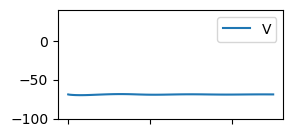

In [11]:
#p_Ix =  25 #mA ?
#iv_v = -50
#iv_n = 0.1

# y0 = V, y1 = n, y2 = m , y3 = h

def_I   = 0.0
def_V   = -69
def_n   = 0.34
def_m   = 0.05
def_h   = 0.52
def_tM  = 50


@interact(      Ix       =   (  -5   , 125  ,  0.05 ), 
                iv_v     =   ( -100  , 34    ,  0.01) , 
                iv_n     =   (  0   , 1     ,  0.001) , 
                iv_m     =   (  0   , 1     ,  0.001) , 
                iv_h     =   (  0   , 1     ,  0.001) , 
                span_M   =   (  -69   , 100    ,  1) )
def plotFunc( save = False, iv_v = def_V , iv_n = def_n , iv_m = def_m , iv_h = def_h , span_M=def_tM, Ix = def_I ):
    span_t = ( min(0,span_M) , max(0,span_M) )

    fpp_simpleNeuron = partial(fp_simpleNeuron , Ix = Ix)

    sol = sp.integrate.solve_ivp(fpp_simpleNeuron , span_t , (iv_v , iv_n , iv_m , iv_h) , method='LSODA' ) 
    
    
#V vs t
    fig0 = plt.subplot(321)
    plt.plot(sol.t,sol.y[0])
    plt.legend(["V"],loc=1)
    plt.tick_params(labelbottom=False)
    fig0.set_ybound(-100,40)
    fig0.set_ylabel("Voltaje [mV]")

#canales % vs t 
    fig1 = plt.subplot(323 , sharex=fig0)
    list( map(plt.plot , repeat( sol.t), map(lambda x : 100*x , sol.y[1:])  ))
    plt.legend(["n","m","h"],loc=1)
    fig1.set_ybound(0,100)
    fig1.set_ymargin(0.1)
    fig1.set_ylabel("apertura \ndel canal [%]")
    fig1.set_autoscaley_on(False)
    fig1.set_xlabel("tiempo [ms]")

#n+ vs t
    fig2 = plt.subplot(325,sharex=fig0, sharey = fig1)
    plt.plot( sol.t , list( map( lambda x,y:100*(x+y) , sol.y[1] , sol.y[3]  ) ))
    fig2.set_ylabel("porcentaje apertura")
    plt.legend(["n+h"],loc=5)

#V vs canales :: trayecto
    fig3 = plt.subplot(122,sharey=fig1)
    list(map (plt.plot , repeat(sol.y[0]) ,  map(lambda x : 100*x , sol.y[1:])))
    #fig1.set_ybound(-0,100)
    plt.legend(["n","m","h"],loc=1)
    fig3.set_ylabel("apertura del canal [%]")
    fig3.set_xbound(-80,75)
    fig3.set_xlabel("Voltaje [mV]")

    plt.grid(visible=True)    
    plt.subplots_adjust(wspace=0.3)
    plt.savefig( "dibujitos I={Ix:.2f}.png".format(Ix=Ix))  if save else _
    plt.show()
    

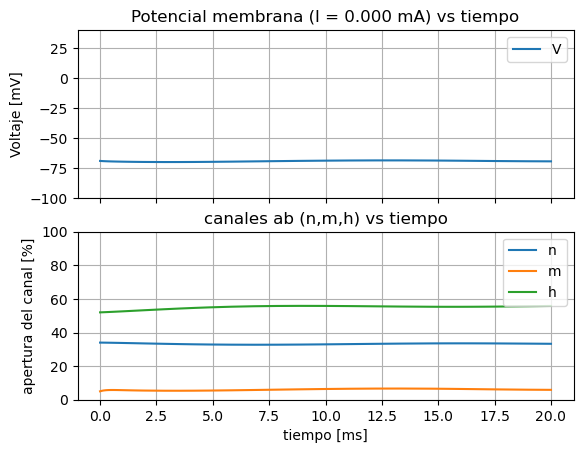

In [8]:
iv_I   = 0.0
iv_V   = -69
iv_n   = 0.34
iv_m   = 0.05
iv_h   = 0.52
span_M = 20 # ms
# y0 = V, y1 = n
#@interact(Ix = (0,50.0,0.05), iv_v = (-10,10,0.01) , iv_n = (0,1,0.001) , span_M = (0,10,0.1) )
span_t = ( 0 , span_M )
fpp_simpleNeuron = partial(fp_simpleNeuron , Ix = iv_I)
            

sol = sp.integrate.solve_ivp(fpp_simpleNeuron , span_t , [ iv_V , iv_n , iv_m , iv_h] , method='LSODA', dense_output=True )


fig0 = plt.subplot(211)
plt.title("Potencial membrana (I = {Iin:1.3f} mA) vs tiempo".format(Iin=iv_I) )
plt.grid(visible=True)
plt.plot(sol.t,sol.y[0])
plt.legend(["V"],loc=1)
plt.tick_params(labelbottom=False)
fig0.set_ybound(-100,40)
fig0.set_ylabel("Voltaje [mV]")

fig1 = plt.subplot(212 , sharex=fig0)
plt.title("canales ab (n,m,h) vs tiempo")
plt.grid(visible=True)
list( map(plt.plot , repeat( sol.t), map(lambda x : 100*x , sol.y[1:])  ))
plt.legend(["n","m","h"],loc=1)
fig1.set_ybound(0,100)
fig1.set_ylabel("apertura del canal [%]")
fig1.set_xlabel("tiempo [ms]")
plt.show()


#plt.legend(["V({vi} mV)".format(vi=iv_v), "n({ni})".format(ni=iv_n), "m","h"], loc= 1)
#plt.axhline(y=0)
#plt.savefig("out_vnm_i{ix}.png".format(ix = p_Ix))

#template = "{p}: {t:2.3f} \t->\t{v:2.3f} \t"
#sample = np.linspace(0,len(sol.t)-1 , 10 , dtype=int)
#for s in sample:
#    print(template.format(p=s,t= sol.t[s] , v=sol.y[0][s] ) )
#

#### lo de abajo solo es para sacar el dibujo con varios valores de Ix.


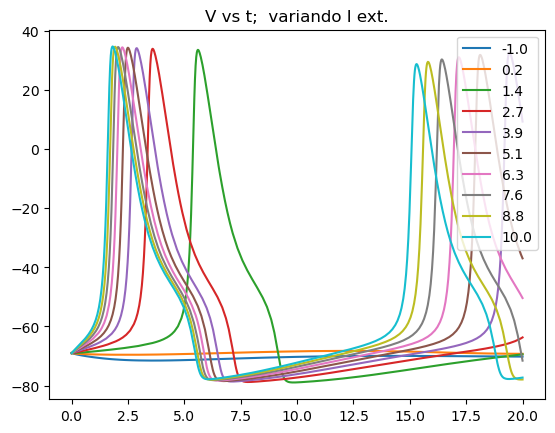

In [9]:

#map eval
p_Ixr = np.linspace(-1,10,10)

sols = map( partial(sp.integrate.solve_ivp, t_span=span_t, y0 = [iv_V,iv_n,iv_m, iv_h], method='LSODA' ) ,
        map( lambda x : partial(fp_simpleNeuron , Ix = x ) ,  p_Ixr )
        )
def plotF (s):
    plt.plot( s.t , s.y[0] ) #"Ix = {val}".format(val = s[0]) )
    plt.legend( list(map(lambda l : "{i:2.1f}".format(i=l) , p_Ixr) ), loc=1)
plt.title("V vs t;  variando I ext.")
list(map(plotF,sols))
    #plt.savefig("out.png")

plt.show()
plt.close()